Задание №1, 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

M = 1000  # Количество выборок для численного моделирования
n_values = [10, 20, 50, 100, 200]  # Размеры выборок
alpha = 0.05
M = 1000
sample_len = 10000  # Размер каждой выборки (чтобы получить стабильную оценку)
distribution_types = ['normal', 'uniform', 'exponential']
mad_std_ratios = {}

In [2]:
# Генерация выборок
def generate_samples(dist_type, num_samples):
    if dist_type == 'normal':
        return np.random.normal(0, 1, num_samples)
    elif dist_type == 'uniform':
        return np.random.uniform(-(3)**0.5, 3**0.5, num_samples)
    elif dist_type == 'exponential':
        return np.random.exponential(1, num_samples) - 1

import numpy as np

# Параметры
M = 1000  # Количество выборок
sample_len = 10000  # Размер каждой выборки (чтобы получить стабильную оценку)

# Генерация выборок
def generate_samples(distribution, n):
    if distribution == 'normal':
        return np.random.normal(0, 1, n)
    elif distribution == 'uniform':
        return np.random.uniform(0, 1, n)
    elif distribution == 'exponential':
        return np.random.exponential(1, n) - 1

In [3]:
# Функция для расчета коэффициента MAD/std
def compute_mad_std_ratio(sample_set):
    mad_values = []
    std_values = []
    for sample in sample_set:
        median_value = np.median(sample)
        mad = np.median(np.abs(sample - median_value))
        std_dev = np.std(sample)
        mad_values.append(mad)
        std_values.append(std_dev)
    return np.mean(mad_values) / np.mean(std_values)


In [4]:
for dist_type in distribution_types:
    sample_set = [generate_samples(dist_type, sample_len) for _ in range(M)]

    # Расчет константы MAD/std
    mad_constant = compute_mad_std_ratio(sample_set)

    mad_std_ratios[dist_type] = mad_constant

    print(f"X ~ {dist_type}")
    print(f" MAD const: {mad_constant:.4f}\n")

X ~ normal
 MAD const: 0.6744

X ~ uniform
 MAD const: 0.8657

X ~ exponential
 MAD const: 0.4811



Задание №3

In [5]:
def count_outliers(sample, method, k):
    count_outliers = 0
    if method == 'z_score':
        z_scores = (sample - np.mean(sample)) / np.std(sample)
        count_outliers += np.sum(np.abs(z_scores) > k)
    elif method == 'modified_z_score':
        median = np.median(sample)
        mad = np.median(np.abs(sample - median))
        if mad != 0:
            z_mod_scores = (sample - median) / mad
        else:
            z_mod_scores = np.zeros_like(sample)
        count_outliers += np.sum(np.abs(z_mod_scores) > k)
    elif method == 'boxplot':
        q1, q3 = np.percentile(sample, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        count_outliers += np.sum((sample < lower_bound) | (sample > upper_bound))
    return count_outliers

def critical_value(samples, method, alpha, dist="normal"):
    def rejection_rate(k):
        total_count = 0
        total_outliers = 0
        for sample in samples:
            total_outliers += count_outliers(sample, method, k)
            total_count += len(sample)
        return abs(total_outliers / total_count - alpha)
    return rejection_rate(0.05)


normal -0.01768676785373071 1.0751022137803914
normal 0.05480651489964208 0.9604489913110147
normal 0.15734380029125739 0.7218813144063384
normal -0.10471733006765334 1.1469438322856274
normal 0.04116538067664774 1.0083555561387927
uniform 0.48664059608524124 0.06771539691445456
uniform 0.4748604483573886 0.0769835622126246
uniform 0.5267681259969038 0.10473351953689257
uniform 0.5171367090832348 0.0774710561902036
uniform 0.4705393861837942 0.08501290769524486
exponential 0.13629397872205154 1.3113375631353852
exponential 0.028699466043306053 0.7301700057882707
exponential -0.09239508927652276 1.090787014102378
exponential -0.029295121944922807 0.774583956324466
exponential 0.005907791319887767 1.0510415235908797


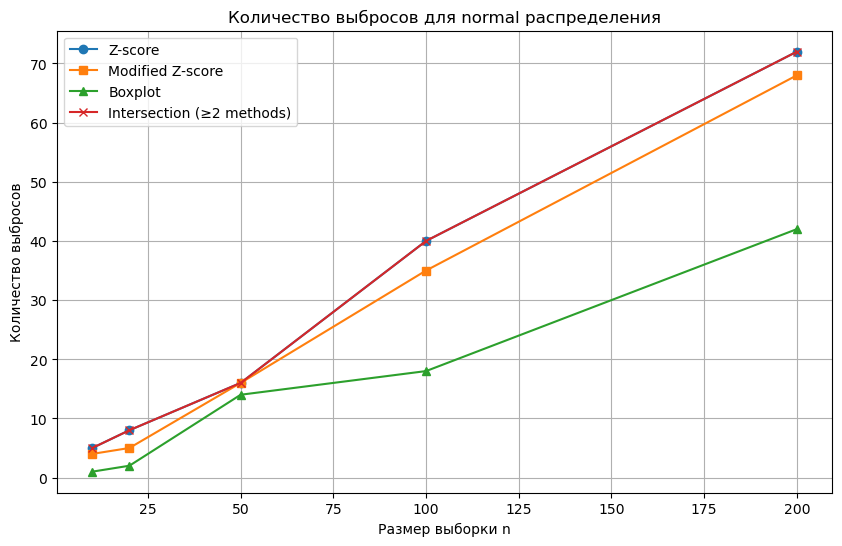

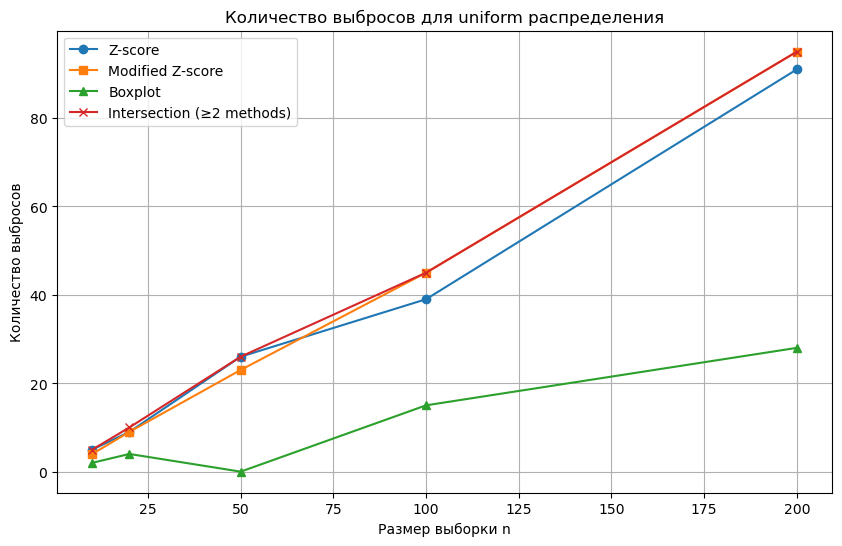

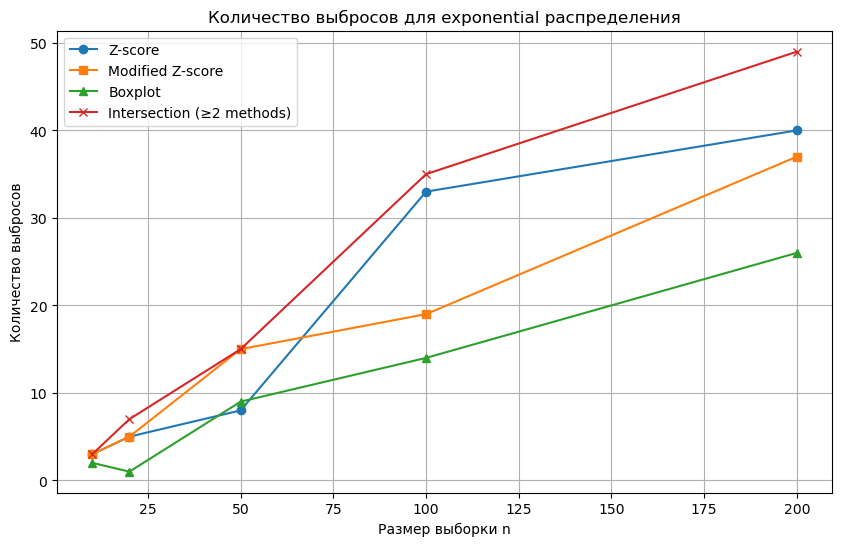

In [6]:
mad_constants = {
    'normal': 0.6746,
    'uniform': 0.8659,
    'exponential': 0.4813
}
distributions = ['normal', 'uniform', 'exponential']
results = {dist: {'z_score': [], 'modified_z_score': [], 'boxplot': [], 'intersection': []} for dist in distributions}
for dist in distributions:
    # Численное моделирование для определения порогов
    samples_modeling = [generate_samples(dist, 10000) for _ in range(M)]

    z_crit = critical_value(samples_modeling, 'z_score', alpha)
    mod_z_crit = critical_value(samples_modeling, 'modified_z_score', alpha)
    boxplot_k = critical_value(samples_modeling, 'boxplot', alpha)

    # Получение константы MAD/std для текущего распределения
    k_mod = mad_constants[dist]

    for n in n_values:
        # Сгенерировать выборку
        sample = generate_samples(dist, n)
        print(dist, np.mean(sample), np.var(sample))
        # Z-score
        z_scores = (sample - np.mean(sample)) / np.std(sample)
        outliers_z = np.abs(z_scores) > z_crit

        # Модифицированный Z-score (учитываем домножение на k_mod)
        median = np.median(sample)
        mad = np.median(np.abs(sample - median))
        mod_z_scores = k_mod * (sample - median) / mad
        outliers_mod_z = np.abs(mod_z_scores) > mod_z_crit
        
        # Boxplot
        q1, q3 = np.percentile(sample, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - boxplot_k * iqr
        upper_bound = q3 + boxplot_k * iqr
        outliers_boxplot = (sample < lower_bound) | (sample > upper_bound)

        # Подсчет выбросов
        count_z = np.sum(outliers_z)
        count_mod_z = np.sum(outliers_mod_z)
        count_boxplot = np.sum(outliers_boxplot)

        # Пересечение выбросов
        combined_outliers = outliers_z + outliers_mod_z + outliers_boxplot
        intersection_count = np.sum(combined_outliers >= 1)

        # Сохранение результатов
        results[dist]['z_score'].append(count_z)
        results[dist]['modified_z_score'].append(count_mod_z)
        results[dist]['boxplot'].append(count_boxplot)
        results[dist]['intersection'].append(intersection_count)


# Построение графиков
for dist in distributions:
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, results[dist]['z_score'], label='Z-score', marker='o')
    plt.plot(n_values, results[dist]['modified_z_score'], label='Modified Z-score', marker='s')
    plt.plot(n_values, results[dist]['boxplot'], label='Boxplot', marker='^')
    plt.plot(n_values, results[dist]['intersection'], label='Intersection (≥2 methods)', marker='x')
    plt.title(f'Количество выбросов для {dist} распределения')
    plt.xlabel('Размер выборки n')
    plt.ylabel('Количество выбросов')
    plt.legend()
    plt.grid(True)
    plt.show()


Домашнее задание

Processing normal distribution


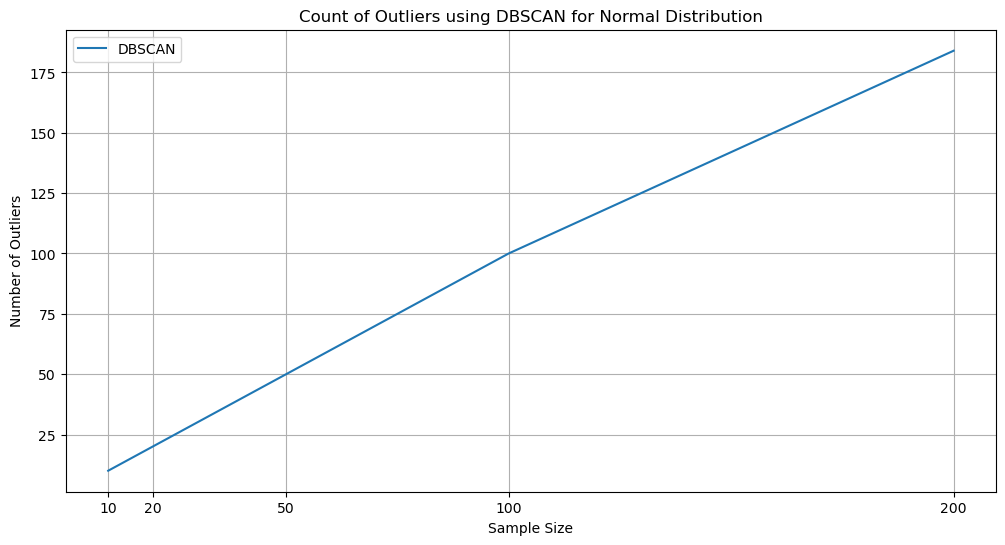

Processing uniform distribution


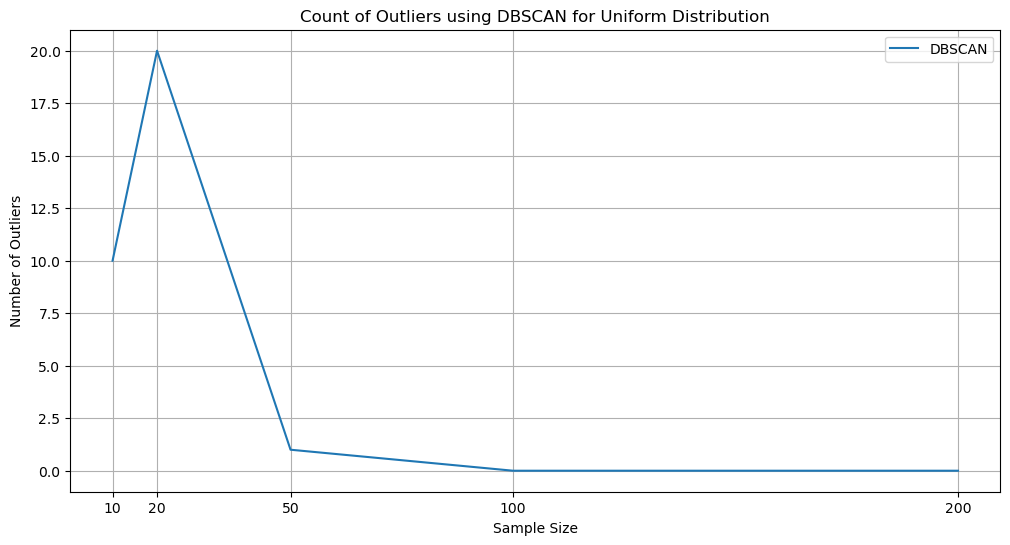

Processing exponential distribution


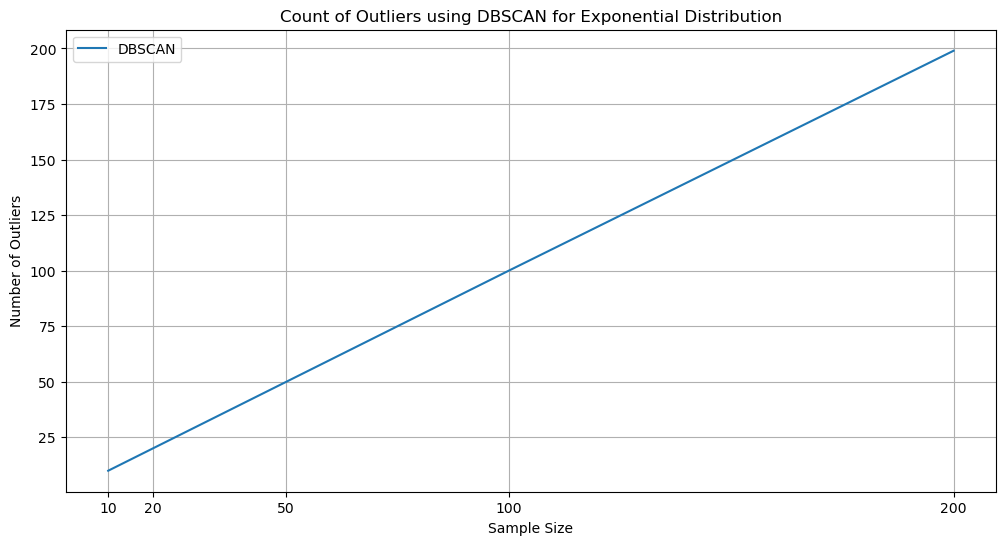

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# === Генерация выборок ===
def generate_samples(dist_type, num_samples):
    if dist_type == 'normal':
        return np.random.normal(0, 1, num_samples)
    elif dist_type == 'uniform':
        return np.random.uniform(-(3)**0.5, 3**0.5, num_samples)
    elif dist_type == 'exponential':
        return np.random.exponential(1, num_samples) - 1

# === Метод DBSCAN для определения выбросов ===
def dbscan_outlier_detection(samples):
    results_dbscan = {}
    for n, sample_list in samples.items():
        results_dbscan[n] = []
        for sample in sample_list:
            db = DBSCAN(eps=0.5, min_samples=2).fit(sample.reshape(-1, 1))
            # Признак выброса = -1 в DBSCAN
            outliers = np.where(db.labels_ == -1)[0]
            results_dbscan[n].extend(outliers)
    return results_dbscan

# === Визуализация результатов DBSCAN ===
def count_dbscan_outliers_and_plot(results, dist_name):
    counts_dbscan = []

    for n in sample_sizes:
        dbscan_count = len(set(results[n]))
        counts_dbscan.append(dbscan_count)

    plt.figure(figsize=(12, 6))
    plt.plot(sample_sizes, counts_dbscan, label='DBSCAN')
    plt.title(f'Count of Outliers using DBSCAN for {dist_name} Distribution')
    plt.xlabel('Sample Size')
    plt.ylabel('Number of Outliers')
    plt.xticks(sample_sizes)
    plt.legend()
    plt.grid()
    plt.show()

# === Основной блок программы ===
M = 1000  # Количество выборок для численного моделирования
n_values = [10, 20, 50, 100, 200]  # Размеры выборок
sample_sizes = n_values
sample_len = 10000  # Размер каждой выборки для стабильной оценки

distribution_types = ['normal', 'uniform', 'exponential']
samples = {dist: {n: [generate_samples(dist, n) for _ in range(M)] for n in n_values} for dist in distribution_types}

# Применение метода DBSCAN для различных распределений
for dist_type in distribution_types:
    print(f"Processing {dist_type} distribution")
    dist_samples = samples[dist_type]
    dbscan_results = dbscan_outlier_detection(dist_samples)
    count_dbscan_outliers_and_plot(dbscan_results, dist_type.capitalize())
